In [1]:
import sys
sys.path.append("../")

from langgraph_swarm.router import Agent, create_swarm_workflow, tool
from langgraph_swarm.util import default_print_messages, get_agent_name_from_message
from langgraph_swarm.repl import run_demo_loop
from langchain_openai import ChatOpenAI

In [2]:
from typing import Annotated
from langgraph.prebuilt.tool_node import InjectedState

@tool(response_format="content_and_artifact")
def process_refund(item_id: str, context_variables: Annotated[dict, InjectedState("context_variables")], reason: str="NOT SPECIFIED"):
    """
    Refund an item. Refund an item. Make sure you have the item_id of the form item_... Ask for user confirmation before processing the refund.
    
    Args:
        item_id: The ID of the item to refund.
        reason: The reason for the refund. Defaults to "NOT SPECIFIED".
    """
    user_id = context_variables.get("user_id", "unknown")
    print(f"[mock] Refunding item {item_id} because {reason} for user {user_id}...")
    return "Success!", {"context_variables": {"reason": reason}}

@tool
def apply_discount():
    """
    Apply a discount to the user's cart.
    
    Args:
        None
    """
    print("[mock] Applying discount...")
    return "Applied discount of 11%"



sales_agent = Agent(
    name="Sales Agent",
    instructions="Be super enthusiastic about selling bees.",
    backlink=False
)
refunds_agent = Agent(
    name="Refunds Agent",
    instructions="Help the user with a refund. If the reason is that it was too expensive, offer the user a refund code. If they insist, then process the refund.",
    backlink=False,
    functions=[process_refund, apply_discount],
)
triage_agent = Agent(
    name="Triage Agent",
    instructions="Determine which agent is best suited to handle the user's request, and transfer the conversation to that agent.",
    # back link to this agent from all handoff agents
    backlink=True,
    handoffs = [sales_agent, refunds_agent]
)

### Use low level api `create_swarm_workflow`

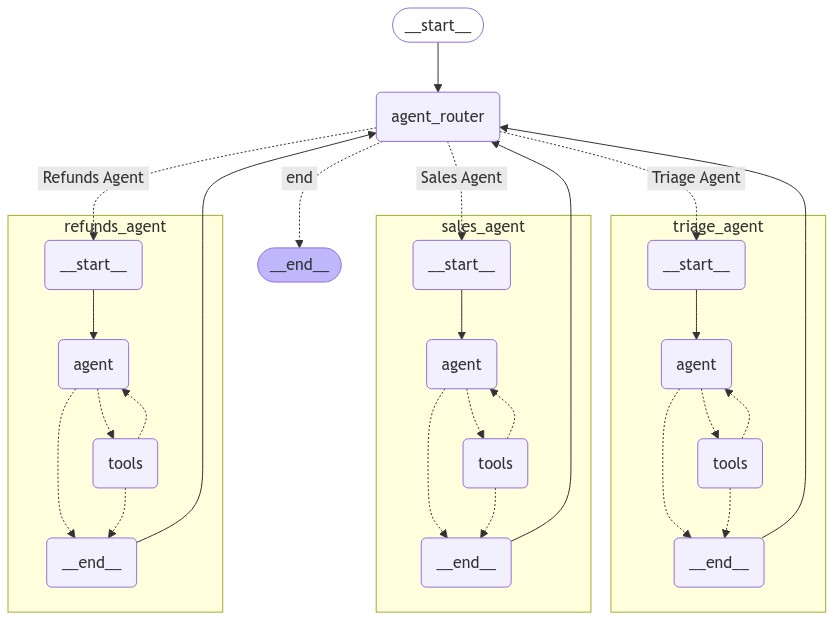

{'Triage Agent': (Agent(name='Triage Agent', model='llama3.2', instructions="Determine which agent is best suited to handle the user's request, and transfer the conversation to that agent.", handoffs=[Agent(name='Sales Agent', model='llama3.2', instructions='Be super enthusiastic about selling bees.', handoffs=[], backlink=False, functions=[], tool_choice=None, parallel_tool_calls=True), Agent(name='Refunds Agent', model='llama3.2', instructions='Help the user with a refund. If the reason is that it was too expensive, offer the user a refund code. If they insist, then process the refund.', handoffs=[], backlink=False, functions=[StructuredTool(name='process_refund', description='Refund an item. Refund an item. Make sure you have the item_id of the form item_... Ask for user confirmation before processing the refund.\n\nArgs:\n    item_id: The ID of the item to refund.\n    reason: The reason for the refund. Defaults to "NOT SPECIFIED".', args_schema=<class 'langchain_core.utils.pydanti

In [6]:
from langchain_core.messages import HumanMessage
from langgraph_swarm.util import default_print_messages

llm = ChatOpenAI(model="llama3.2")

agent_map = {}

wf = create_swarm_workflow(
        llm=llm,
        starting_agent=triage_agent,
        print_messages=default_print_messages,
        with_user_agent=False,
        debug=True,
        agent_map=agent_map
)

from IPython.display import Image, display
image = wf.get_graph(xray=True).draw_mermaid_png()
display(Image(image))

print(agent_map)

In [7]:
for k, v in agent_map.items():
    print(k, v[2])

Triage Agent {'transfer_to_sales_agent': 'Sales Agent', 'transfer_to_refunds_agent': 'Refunds Agent'}
Sales Agent {'transfer_to_triage_agent': 'Triage Agent'}
Refunds Agent {'transfer_to_triage_agent': 'Triage Agent'}


### Use Swarm client and streaming

In [ ]:
from langgraph_swarm.router import Swarm
from langgraph_swarm.util import default_print_messages
from langchain_core.messages import HumanMessage
cliet = Swarm(agent=triage_agent, debug=True, print_messages=default_print_messages)
resp = cliet.run(
    messages=[HumanMessage(content="I need a refund")],
    stream=True,
)

for _chunk in resp:
    print("Console:", _chunk)

In [ ]:
messages = [HumanMessage(content="I need a refund", name="User ")]
context_variables = {"user_id": "123"}
wf.invoke(input={"messages": messages, "agent_name": triage_agent.name, "handoff": True, "context_variables": context_variables})

In [ ]:

messages = [HumanMessage(content="I need a refund for item_123 because it was too expensive", name="User ")]
context_variables = {"user_id": "123"}
wf.invoke(input={"messages": messages, "agent_name": refunds_agent.name, "handoff": True, "context_variables": context_variables})

### Use `run_demo_loop`

In [ ]:
user_inputs = [
    "I need a refund",
    "I need a refund for item_12345",
    "Fine, it's done. back to triage",
    "I want to talk to sales",    
    "/end",
]

context_variables = {"user_id": "123"}

run_demo_loop(starting_agent=triage_agent, context_variables=context_variables, debug=False, user_inputs=user_inputs, stream=True)